# Lecture 5, Evolution in time and space

> Advection and diffusion in 1D

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import display

# Evolution in time and space: Advection and diffusion in 1D

So far we have been looking at dynamics in time, for example how does the temperature of the Earth change over time. But the Earth does not have a single, uniform temperature; rather, at a particular moment in time, different places on Earth are at different temperatures, and those different temperatures change over time due to several mechanisms. 


In this notebook we will look at two fundamental mechanisms: **advection** and **diffusion**. Let's think about the temperature in the ocean. Since the ocean is a fluid that is in motion, a warm "parcel" of water can flow (move) to a new location due to the physical motion of the water itself; this is **advection**.  And even if the water doesn't move, temperature or a higher concentration of some substance dissolved in the fluid can spread out due to molecular mechanisms; this is **diffusion**.

In this notebook we will restrict ourselves to 1 space dimension.
So we will think about the temperature $T$, for example, being a function 
$$T(t, x)$$
of

- time: $t$
- space: $x$

We want to calculate a value of the temperature $T$ at each point $(t, x)$.


## Temperature profiles and discretization

An ordinary differential equation needs an initial value for each variable. Similarly, we will need an initial *function* $T_0(x)$ that gives us the temperature at each position $x$. Let's suppose that the position is restricted to the interval $[0, L_x]$.

As usual, to represent the continuous function $T_0(x)$ on a computer, we will need to **discretise** it in some way, i.e. *approximate* the continuous function by a *finite* set of numbers in the computer.

The simplest (but far from the only!) discretisation method is to **sample** the function at discrete **grid points** (or **nodes**) $x_i$, for $i = 1, \dots, N_x$. For simplicity we will take these equally spaced, with spacing $x_{i+1} - x_i =: \delta x := L_x / N_x$.

For example, let's consider an initial temperature profile given by a sine curve:


In [2]:
def t0(x):
    return np.sin(2*np.pi * x)

and define the grid points as follows:


In [3]:
Nx = 20
Lx = 1.0

deltax = Lx / Nx

xs = np.arange(0.025, Lx, deltax)

In [4]:
xs

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

It turns out to be a good idea to take the grid points at the *centre* of each interval, so that we have $N_x$ intervals and $N_x$ grid points, starting at $x_1 = \delta x/2$ and finishing at $x_N = L_x - \delta x / 2$.


We call such a function of $x$ at a given time a **temperature profile**. Let's draw it as a function and as a heatmap:


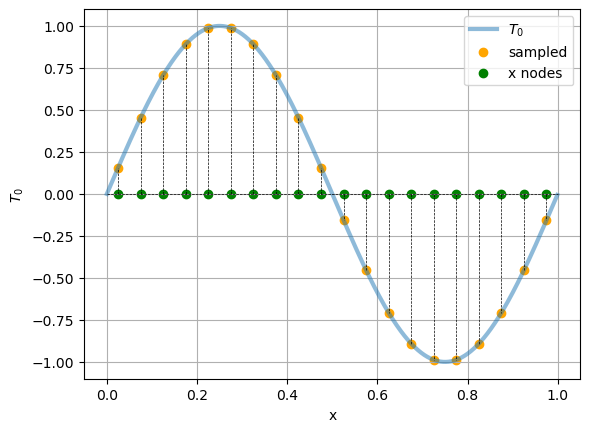

In [5]:
t = np.arange(0,Lx, 0.001)

plt.plot(t, t0(t), label = "$T_0$", lw = 3, alpha = 0.5)
plt.scatter(xs, t0(xs), label = "sampled", color = "orange")
plt.scatter(xs, np.zeros((xs.size)), color ="green", label = "x nodes")
plt.hlines(0,xmin=0, xmax = Lx, color = "black", ls = "--", lw = 0.5)
for x in xs:
    plt.plot([x, x], [0, t0(x)], color = "black", ls = "--", lw = 0.5)
plt.xlabel("x")
plt.ylabel("$T_0$")
plt.grid()
plt.legend()

We will denote by $T^0_i$ the initial temperature at grid point number $i$.


A useful way to think about $T^n_i$ is as the (spatial) average of $T(t_n, x)$ over the interval of positions between neighbouring grid points, so $T_i$ is the average over the interval between $x_i - \frac{\delta x}{2}$ and $x_i + \frac{\delta x}{2}$. We can thus think of the following **piecewise constant** approximation to the original continuous function:


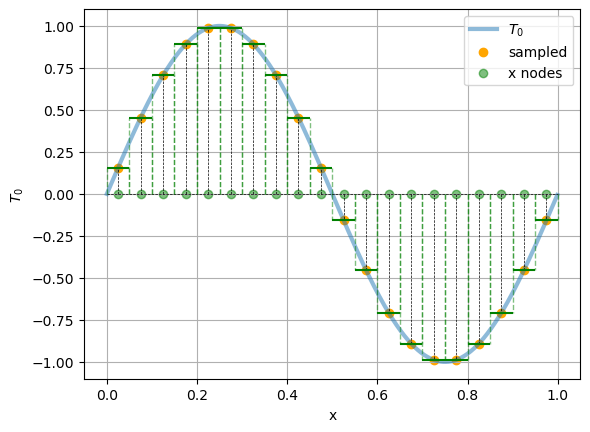

In [6]:
t = np.arange(0, Lx, 0.001)

plt.plot(t, t0(t), label = "$T_0$", lw = 3, alpha = 0.5)
plt.scatter(xs, t0(xs), label = "sampled", color = "orange")
plt.scatter(xs, np.zeros((xs.size)), color ="green", label = "x nodes", alpha = 0.5)
plt.hlines(0,xmin=0, xmax = Lx, color = "black", ls = "--", lw = 0.5)

for x in xs:
    plt.plot([x, x], [0, t0(x)], color = "black", ls = "--", lw = 0.5)
    plt.xlabel("x")
    plt.hlines(t0(x), xmin = x-deltax/2, xmax = x+deltax/2, color = "green")
    plt.vlines(x-deltax/2, ymin=0, ymax=t0(x), color = "green", alpha = 0.5, ls="--", lw = 1)
    plt.vlines(x+deltax/2, ymin=0, ymax=t0(x), color = "green", alpha = 0.5, ls="--", lw = 1)
plt.ylabel("$T_0$")
plt.grid()
plt.legend()

## Advection

Now let's think of this as the temperature in a fluid, and let's suppose that the fluid is moving to the right with a constant, uniform speed $U$. (**Uniform** here means that the speed is the same in all parts of the fluid.) Then the temperature profile should also *move with the fluid*. We call a quantity, such as the temperature, that is carried along with the fluid a **tracer**.


If we fix our attention at a single point in space, say the grid point $x_i$, the temperature there will vary over time due to the motion of the fluid. How it varies in time depends on the values at neighbouring grid points, since they determine how much heat will be *transported into* the current cell.

Let's think about a time-stepping algorithm, and let $\delta t$ be the duration of a time step. We'll denote by $T^n_i$ the approximate value of $T$ to calculate at position $x_i$ and at the $n$th time step $t_n$, i.e. an approximation of $T(t_n, x_i)$, where $t_n = n \, \delta t$. 
For example, $T^{n+1}_i \simeq T(t_n + \delta t, x_i)$ and $T^{n}_{i+1} \simeq T(t_n, x_i + \delta x)$.


**Note** that the superscript $n$ in these algorithms does not denote a power; it's just a label for the time step. We could write $T_i^{(n)}$ instead, but that is annoying to both write and read, so we suppress the parentheses.

Suppose the fluid is moving to the right with speed $U$. During a time step of duration $\delta t$, the temperature $T^n_i$ at cell $i$ changes due to the amount of heat that leaves cell $i$, and the amount that enters that cell.
Most of the fluid that starts within cell $i$ remains within that cell during the time step (if the time step is short enough). Only fluid that is within a distance $U \, \delta t$ from the boundary of the cell will cross over that cell. So a *proportion* $(U \, \delta t) / \delta x$ of the amount in cell $i$ crosses the boundary.


Hence, roughly an amount $T^n_i (U \delta t) / \delta x$ will leave cell number $i$ and cross into cell $i+1$ (the cell to the right). Similarly, an amount $T^n_{i-1} (U \delta t) / \delta x$ will *enter* cell $i$ from the neighbouring cell $i-1$ on the left. Hence we have
$$T^{n+1}_i = T^{n}_i + (T^n_{i-1} - T^n_{i})\, U \, \delta t / \delta x.$$

Thus
$$\frac{T^{n+1}_i - T^{n}_i}{\delta t} =  \frac{T^n_{i-1} - T^n_{i}}{\delta x}\, U.$$

Taking the continuum limit when $\delta t \to 0$ and $\delta x \to 0$, we recognise the definition of **partial derivatives** with respect to time and space variables from multivariable calculus. (Note the different indices that change on the two sides of the equation.) 
Denoting these partial derivatives using $\partial$, we arrive at the **advection equation**:
$$\frac{\partial T(t, x)}{\partial t} = -U \frac{\partial T(t, x)}{\partial x},$$
or for short
$$\frac{\partial T}{\partial t} = -U \frac{\partial T}{\partial x}.$$
Since $T$ is a function of both $x$ and $t$, and this equation involves partial derivatives with respect to both of the independent variables, this is a **partial differential equation** (PDE). It describes how the function $T(t, x)$ changes continuously as a function both of time and space. 
Although there are some analytical methods to solve PDEs, often it's necessary to use numerical methods. Here we'll look at simple numerical methods to solve such equations.

## Numerics for the advection equation

Let's return to the version of the equation in which the value at the *following* time step is isolated:
$$T^{n+1}_i = T^{n}_i - \left( U \frac{\delta t}{\delta x} \right) (T^n_{i} - T^n_{i-1}).$$
In the last term on the right-hand side, we see that we require combinations of values of $T$ at the *same* time step from *different* places, with certain coefficients.


There are many approaches to implementing this numerically. The simplest is to directly transcribe the equation for the $i$th entry of the vector.
Calling `T` the current vector, i.e. $\mathbf{T}^n := (T^n_i)_{i=1, \ldots, N_x}$, and `T′` the new vector at the next time step, we have the following basic expression:

> T′[i] = T[i] + δt * U * (T[i-1] - T[i]) / δx

But now we realise a problem: What should we do when $i=0$? This will try to access the index -1 of the vector `T`, which does not exist!

This illustrates the necessity of choosing **boundary conditions** that specify what happens at the edge of the domain.
For simplicity we will choose to use **periodic boundary conditions**. This is a convenient mathematical fiction that allows us to treat all cells as being on the same footing, by wrapping the system around a torus, so that cells $i=0$ and $i=N_x$ are neighbours.



We can then write this as follows, where we separate out the case $i=0$:


In [7]:
def advection(T, deltat, deltax, U):
    N = len(T)
    T2 = T.copy()
    
    for i in range(1, N):
        T2[i] = T[i] - deltat * U * (T[i]-T[i-1]) / deltax
        
    T2[0] = T[0] - deltat * U * (T[0]-T[-1]) / deltax
    
    return T2

We use a function `plot_func` that carries out a generic time evolution. This is basically the Euler method again, except now we apply it to a vector of values at different points in space at each step. 


In [8]:
deltat = 0.001
U = 0.2
initcondition = t0(xs)

In [9]:
initcondition

array([ 0.15643447,  0.4539905 ,  0.70710678,  0.89100652,  0.98768834,
        0.98768834,  0.89100652,  0.70710678,  0.4539905 ,  0.15643447,
       -0.15643447, -0.4539905 , -0.70710678, -0.89100652, -0.98768834,
       -0.98768834, -0.89100652, -0.70710678, -0.4539905 , -0.15643447])

In [10]:
def plot_func(function, deltat, U, xs, steps, T0 = initcondition):
    T = T0.copy()
    deltax = xs[1] - xs[0]
    for step in range(steps):
        T = function(T, deltat, deltax, U)    
    plt.figure(figsize=(8,8))
    plt.plot(xs, T)
    plt.scatter(xs,T)
    plt.title("{}".format(step*deltat))
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.ylim([-1,1])
    plt.grid()
    plt.tight_layout()
    plt.show()

In [11]:
interact(plot_func, 
         function = fixed(advection),
         steps = widgets.IntSlider(description="Timesteps", value = 1, min = 1, max = 10000, step = 1),
         deltat = fixed(deltat), #widgets.FloatSlider(description = "$\Delta t$",value = 0.001, min = 0.0001, max = 0.01, step = 0.0001, readout_format='.4f'),
         U = fixed(U),         
         xs = fixed(xs),
         T0 = fixed(advection(initcondition, deltat, xs[0], U)));

interactive(children=(IntSlider(value=1, description='Timesteps', max=10000, min=1), Output()), _dom_classes=(…

Unfortunately this does *not* behave as we expect: instead of preserving the shape of the profile over time, it is decaying. This is due to the way we are approximating. 

A better way to discretize the spatial derivative is using the following **centered difference**:
$$\frac{\partial T(t_n, x_i)}{\partial x} \simeq \frac{T^n_{i+1} - T^n_{i-1}}{2 \delta x}$$


In [12]:
def advection2(T, deltat, deltax, U):
    N = len(T)
    T2 = T.copy()
    
    for i in range(1, N-1):
        T2[i] = T[i] - deltat * U * (T[i+1]-T[i-1]) / (2*deltax)
        
    T2[0] = T[0] - deltat * U * (T[1]-T[-1]) / (2*deltax)
    T2[-1] = T[-1] - deltat * U * (T[0]-T[-2]) / (2*deltax)
    
    return T2

In [13]:
interact(plot_func, 
         function = fixed(advection2),
         steps = widgets.IntSlider(description="Timesteps", value = 1, min = 1, max = 10000, step = 1),
         deltat = fixed(deltat),#widgets.FloatSlider(description = "$\Delta t$",value = 0.001, min = 0.0001, max = 0.01, step = 0.0001, readout_format='.4f'),
         U = fixed(U),         
         xs = fixed(xs),
         T0 = fixed(advection(initcondition, deltat, xs[0], U)));
         


interactive(children=(IntSlider(value=1, description='Timesteps', max=10000, min=1), Output()), _dom_classes=(…

## Diffusion

Another key physical process is **diffusion**. This models how temperature or mass spreads out from hot or high concentration regions towards regions where it is cold or where there is a low concentration.
The PDE describing this is the **heat equation**, or **diffusion equation**:

$$\frac{\partial T}{\partial t} = D \frac{\partial^2 T}{\partial x^2}.$$


To obtain a numerical method to solve this equation, we again need to discretise this, in particular the second derivative. One possible discretisation is
$$\frac{\partial^2 T}{\partial x^2}(t_n, x_i) \simeq \frac{T^n_{i+1} - 2 T^n_i + T^n_{i-1}}{\delta x^2}.$$

This may again be transcribed directly into code:


In [14]:
def diffusion(T, deltat, deltax, D):
    N = len(T)
    T2 = T.copy()
    
    for i in range(1, N-1):
        T2[i] = T[i] + deltat * D * (T[i+1]-2*T[i] + T[i-1]) / (deltax**2)
        
    T2[0] = T[0] + deltat * D *     (T[1]-2*T[0] + T[-1]) / (deltax**2)
    T2[N-1] = T[N-1] + deltat * D * (T[0]-2*T[N-1] + T[N-2]) / (deltax**2)
    
    return T2

In [15]:
interact(plot_func, 
         function = fixed(diffusion),
         steps = widgets.IntSlider(description="Timesteps", value = 1, min = 1, max = 10000, step = 1),
         deltat = fixed(deltat),#widgets.FloatSlider(description = "$\Delta t$",value = 0.001, min = 0.0001, max = 0.01, step = 0.0001, readout_format='.4f'),
         U = fixed(0.01),         
         xs = fixed(xs),
         T0 = fixed(advection(initcondition, deltat, xs[0], U)));

interactive(children=(IntSlider(value=1, description='Timesteps', max=10000, min=1), Output()), _dom_classes=(…

## Advection--diffusion

Finally we can combine both mechanisms, to describe a tracer that is both being advected at a constant speed and diffusing. This basically utilises the composition of the advection and diffusion functions:


In [16]:
def advection_diffusion(T, deltat, deltax, U):
    D = 0.01
    temp = advection2(T, deltat, deltax, U)
    return diffusion(temp, deltat, deltax, D)

In [17]:
interact(plot_func, 
         function = fixed(advection_diffusion),
         steps = widgets.IntSlider(description="Timesteps", value = 1, min = 1, max = 10000, step = 1),
         deltat = fixed(deltat),#widgets.FloatSlider(description = "$\Delta t$",value = 0.001, min = 0.0001, max = 0.01, step = 0.0001, readout_format='.4f'),
         U = fixed(0.2),         
         xs = fixed(xs),
         T0 = fixed(advection(initcondition, deltat, xs[0], U)));

interactive(children=(IntSlider(value=1, description='Timesteps', max=10000, min=1), Output()), _dom_classes=(…